# Why does a topological layering emerge in neural networks?
_An example with XOR_

### Question

I found that the scope of action I identified in the mid-term were too unrealistic to begin with. Building the PRT-Complete Gnets and pruning to induce modern architectures was too complex. In order to make progress, I have adapted by narrowing down the scope.

Instead of using a PRT-Complete Gnet and inducing the formation of architectures, I am now investigating a much simpler question:

> Why is the organisation of multi-layer perceptrons into layers helpful for learning?

This represents my original research question narrowed down to the scope of MLPs, and the emergence of architectures down to the emergence of hierarchical, layered structures. The biological implications are still intact: neurons are allowed to form arbitrary connections, not just forward connections (as in traditional MLPs). It is interesting, then, that the brain organise itself into layers, with a direction of information transfer: such as the flow of visual data from V1, via V2, to V3.

Here is another way to frame the same question without starting from an observed phenomenon:

> If we start with a complete network (i.e. every neuron is connected to everything else), how can we induce a layered structure to emerge?

In other words, we are working out the correct inductive biases for a network to organise itself into layers. I have identified two directions through which this question can be investigated: inductive biases in weight initialisation, and inductive biases in training (e.g. pruning and/or modifications to learning algorithm).

### New Approach

The complete network:
- every hidden neurons (non-input neurons) is connected to each other
- for a problem with $k$ outputs, the first $k$ hidden neurons give the output
- to simulate a network with $h$ hidden layers, we evolve the complete network for $h+1$ timesteps

Inspired by the papers I read, I came up with different initialisation strategies:
- upper triangular (enforce topological orderliness)
- prune at the start with a winning lottery
- zeroing out values

And the following different training strategies:
- weight decay (decay weight, with the hope of eventually reducing some useless weights to near zero)
- norm-loss pruning (penalise too high a norm)
- threshold-based pruning (prune all edges with less than a certain weight)
- set-cover pruning (?)

The control standard MLP has the theoretical minimum number of neurons needed to solve XOR (5 neurons). The control complete network has the same number of neurons, but no special initialisation, training, or pruning process. On top of the control complete network, we then inject different inductive biases.

Results are evaluated on several different metrics (all averaged across runs, with mean and standard deviation reported):
- speed of convergence (as measured on the Adam optimiser)
- final network sparsity
- final topological orderliness (weaker requirement)
- final hierarchical orderliness (stronger requirement)

Visualise:
- mean, std of weights across diff runs (emergence)
- top-sort pruning vs other methods of pruning (helpfulness) - accuracy across training

I have started with testing the system on one of the simplest tasks in deep learning: XOR. This is to provide an intuition for the research, and to scout out which methods may work better before moving onto MNIST. I have hoped to be able to apply my findings to MNIST by this point, but unfortunately I have only just finished building the framework for testing the various initialisation and pruning strategies I hope to achieve.

## Libraries & Setup

In [1]:
import sys
sys.path.append('../')

In [5]:
from tqdm import tqdm
from math import sin, pi
from funcs import topk_mask

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
from utils import filter_topk
from layers import CompleteLayer
from inits import Size, Like
from inits import (
    RandomNormal,
    RandomUniform,
    Zeros,
    Triu
)
from pruning import PruneEnsemble
from pruning import (
    NoPrune,
    RandomPrune,
    TopKPrune,
    DynamicTopK,
    ThresholdPrune,
    TriuPrune
)
import losses
from training import train
from evals import LineVisualiser, WeightVisualiser, DirectionalityVisualiser
import experiments

In [4]:
device = 'cpu'

## Generate XOR Data

In [16]:
x = torch.tensor(np.arange(0, 2, 0.1).reshape(-1, 2), dtype=torch.float32).to(device)
y = torch.unsqueeze(torch.sin(x).sum(1), 1).to(torch.float32).to(device)
dataloader = DataLoader(TensorDataset(x, y), batch_size=4, shuffle=True)

## Simple Baseline

  0%|          | 0/5 [00:00<?, ?it/s]/home/yiding/micromamba/envs/nsarc/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 5/5 [00:50<00:00, 10.17s/it]


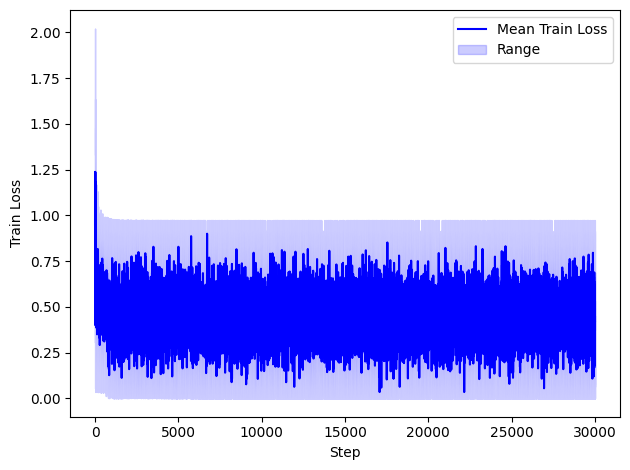

In [19]:
def baseline_setup():
    baseline = nn.Sequential(
        nn.Linear(2, 4, bias=True),
        nn.Sigmoid(),
        nn.Linear(4, 1, bias=True),
        nn.Sigmoid()
    ).to(device)
    criterion = losses.MSELoss()
    optim = torch.optim.Adam(baseline.parameters(), lr=0.01)
    return {
        'model': baseline,
        'train_criterion': criterion,
        'optimiser': optim
    }

visualisers = experiments.run(
    tries=5,
    seed=1,
    setup_fn=baseline_setup,
    visualisers=[
        LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        )
    ],
    n_epochs=10000,
    train_dataloader=dataloader,
    early_stop=3e-3
)

## Complete Network

  0%|          | 0/5 [00:00<?, ?it/s]/home/yiding/Desktop/Research/induced-mlp/notebooks/../losses.py:10: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(x, y, reduction=self.reduction)
/home/yiding/Desktop/Research/induced-mlp/notebooks/../losses.py:10: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(x, y, reduction=self.reduction)
100%|██████████| 5/5 [01:47<00:00, 21.51s/it]


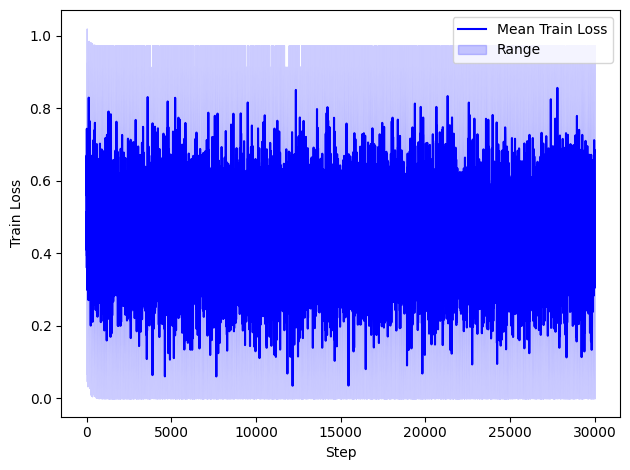

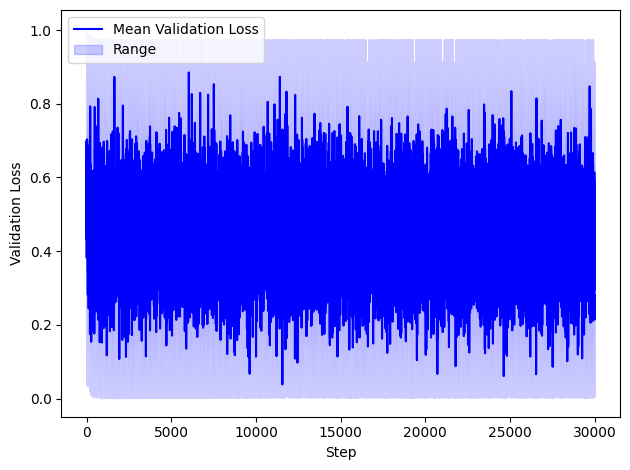

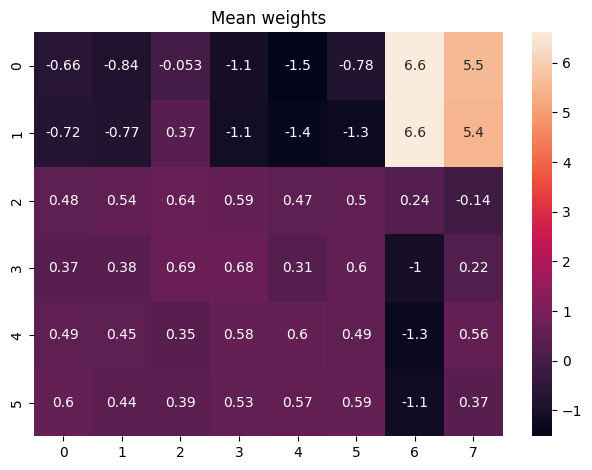

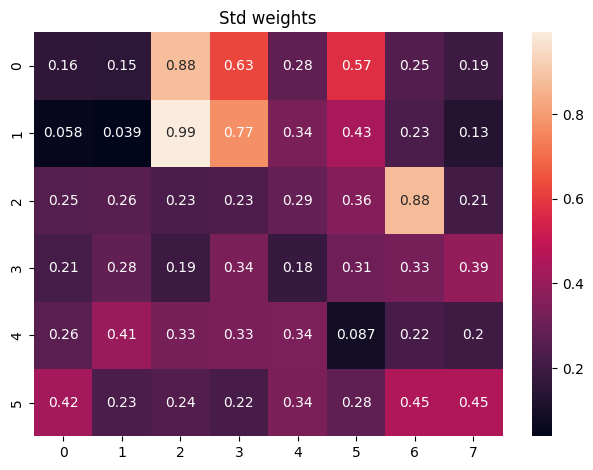

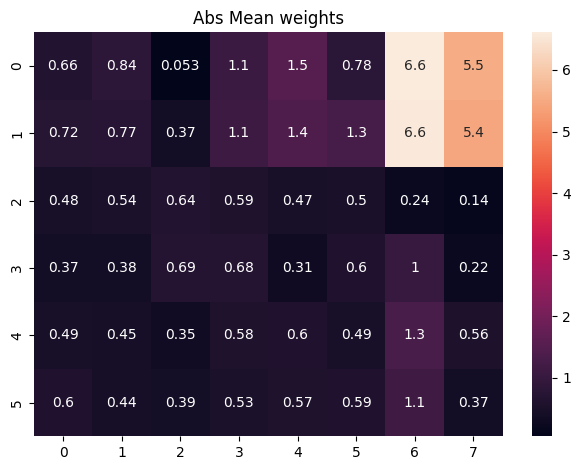

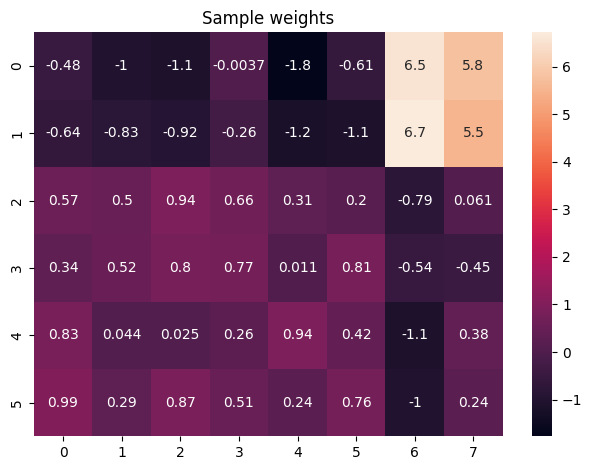

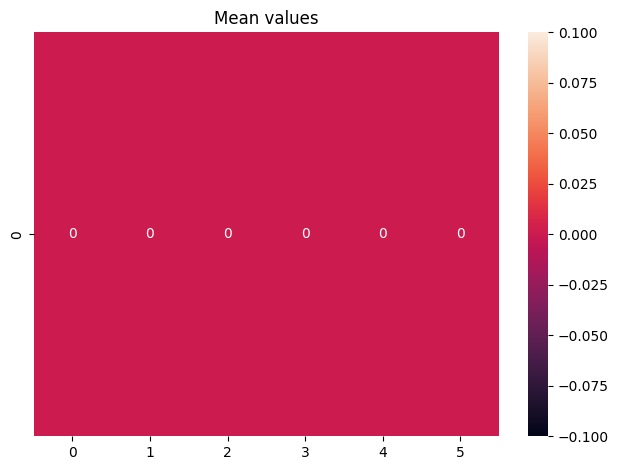

Directionality: 0.28554943203926086


tensor([[0.1043, 0.1585],
        [0.4928, 0.6667],
        [0.9238, 0.9628],
        [0.9938, 0.9971],
        [0.9995, 0.9998],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000]], grad_fn=<SliceBackward0>)

In [20]:
def setup():
    complete = CompleteLayer(
        input_size=2,
        hidden_size=4,
        output_size=2,
        values_init=(Zeros, False),  # try initialising differently
        weights_init=(RandomUniform, True),
        scores_init=(RandomUniform, False),
        bias_init=(Zeros, False),
        activation=F.sigmoid,
        use_bias=False
    ).to(device)
    optim = torch.optim.Adam(complete.parameters(), lr=0.01)
    return {
        'model': complete,
        'optimiser': optim
    }

visualisers, result = experiments.run(
    tries=5,
    seed=1,
    setup_fn=setup,
    visualisers=[
        LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        ),
        LineVisualiser(
            lambda r: (r['val_steps'], r['val_losses']),
            xlabel='Step',
            ylabel='Validation Loss'
        ),
        WeightVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            show = ['mean', 'std', 'abs-mean', 'sample']
        ),
        WeightVisualiser(
            lambda r: r['model'].values,
            name = 'values',
            show = ['mean']
        ),
        DirectionalityVisualiser()
    ],
    n_epochs=10000,
    train_dataloader=dataloader,
    train_criterion=losses.MSELoss(),
    val_dataloader=dataloader,
    val_criterion=losses.MSELoss(),
    early_stop=3e-3,
    pruner=PruneEnsemble({})
)

# compare with other pruning methods
complete = result['model'].to('cpu')
complete.weights = nn.Parameter(complete.weights.triu())
complete(x)

100%|██████████| 5/5 [02:54<00:00, 34.83s/it]


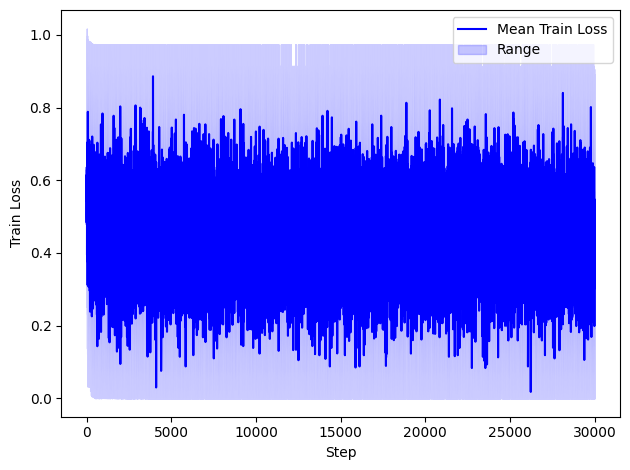

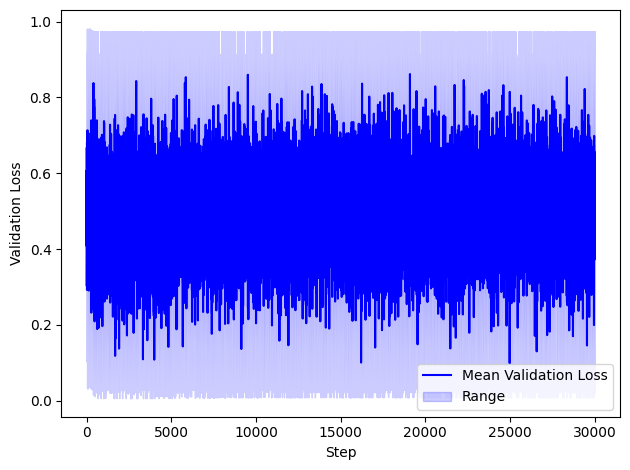

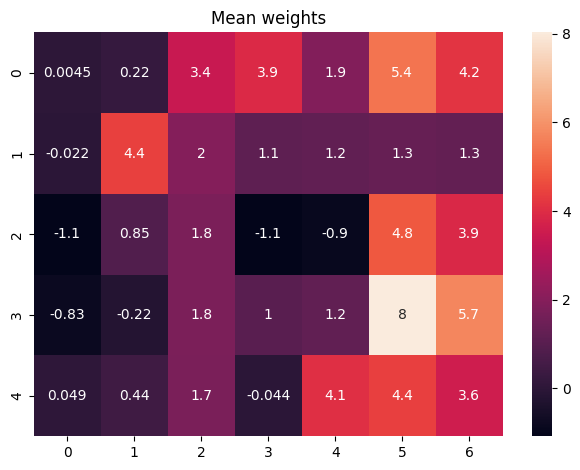

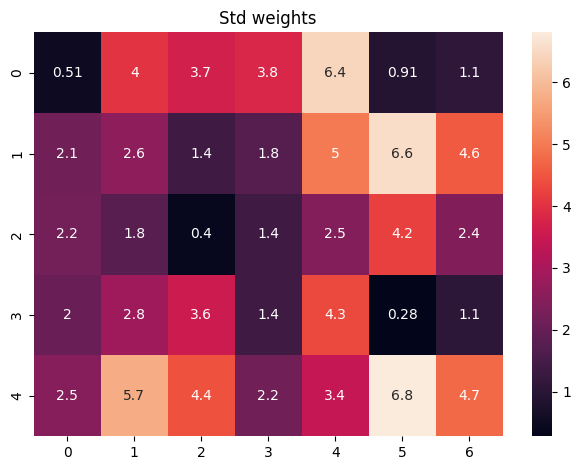

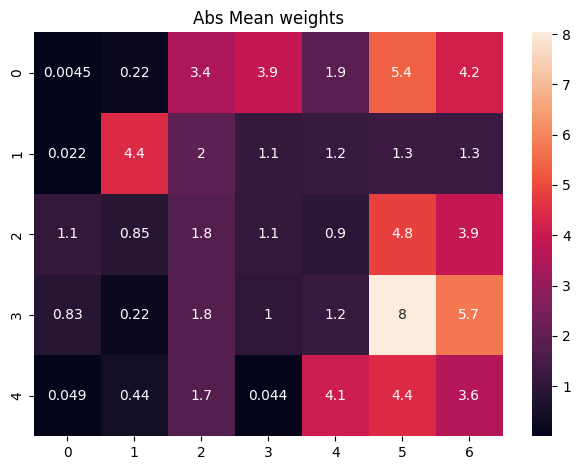

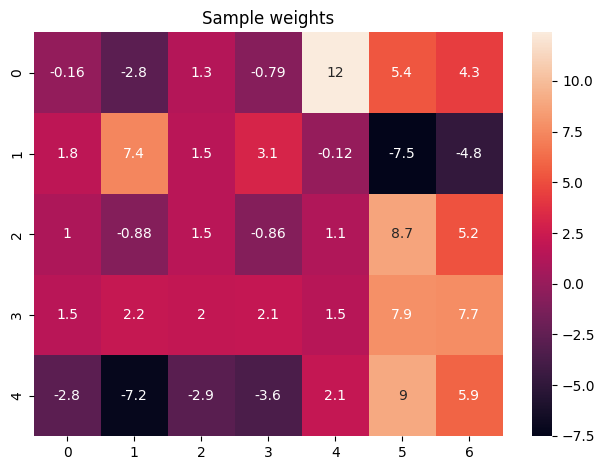

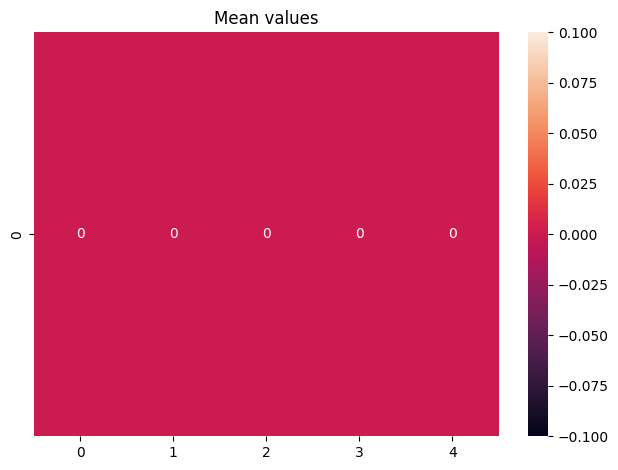

Directionality: 0.7861154079437256


tensor([[0.5311],
        [0.9951],
        [0.9997],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<SliceBackward0>)

In [ ]:
def setup():
    complete = CompleteLayer(
        input_size=2,
        hidden_size=4,
        output_size=1,
        values_init=(Zeros, False),  # try initialising differently
        weights_init=(RandomUniform, True),
        scores_init=(RandomUniform, False),
        bias_init=(Zeros, False),
        activation=F.sigmoid,
        use_bias=False
    ).to(device)
    optim = torch.optim.Adam(complete.parameters(), lr=0.01)
    return {
        'model': complete,
        'optimiser': optim
    }

visualisers, result = experiments.run(
    tries=5,
    seed=2,
    setup_fn=setup,
    visualisers=[
        LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        ),
        LineVisualiser(
            lambda r: (r['val_steps'], r['val_losses']),
            xlabel='Step',
            ylabel='Validation Loss'
        ),
        WeightVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            show = ['mean', 'std', 'abs-mean', 'sample']
        ),
        WeightVisualiser(
            lambda r: r['model'].values,
            name = 'values',
            show = ['mean']
        ),
        DirectionalityVisualiser()
    ],
    n_epochs=10000,
    train_dataloader=dataloader,
    train_criterion=losses.MSELoss(),
    val_dataloader=dataloader,
    val_criterion=losses.MSELoss(),
    its=4,
    early_stop=3e-3,
    pruner=PruneEnsemble({
        'values': NoPrune(),
        'weights': DynamicTopK(p=0.5)
    })
)

# compare with other pruning methods
complete = result['model'].to('cpu')
complete.weights = nn.Parameter(complete.weights.triu())
complete(x)

100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


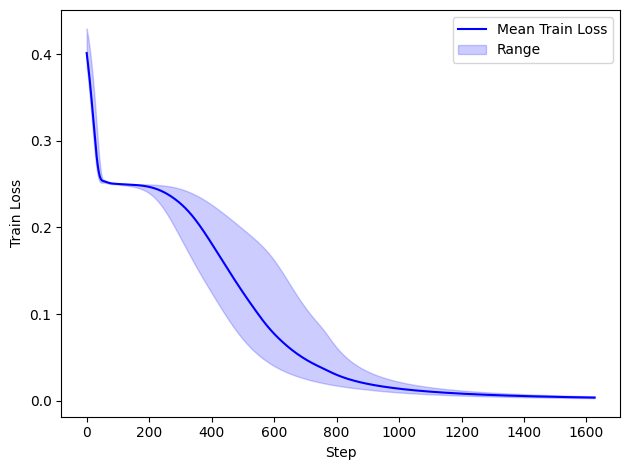

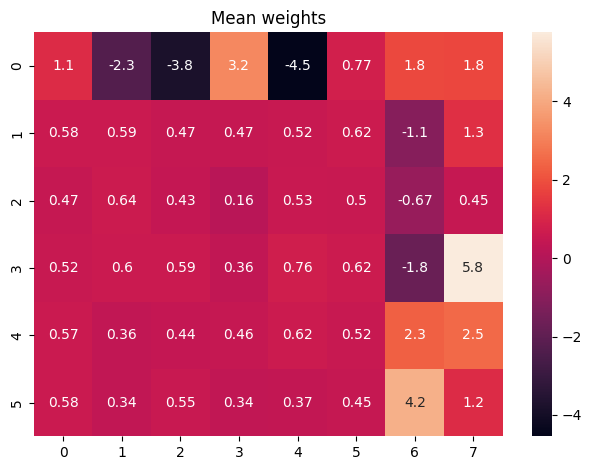

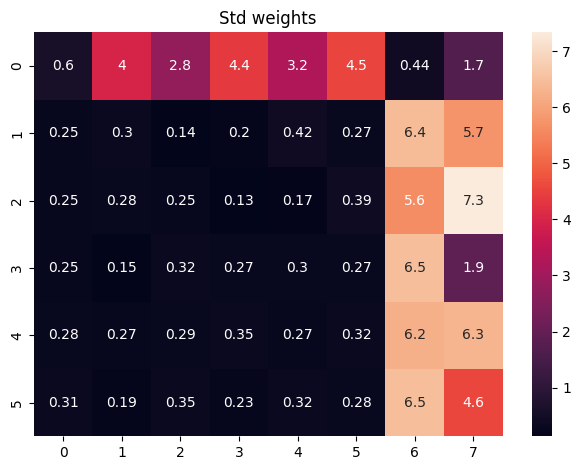

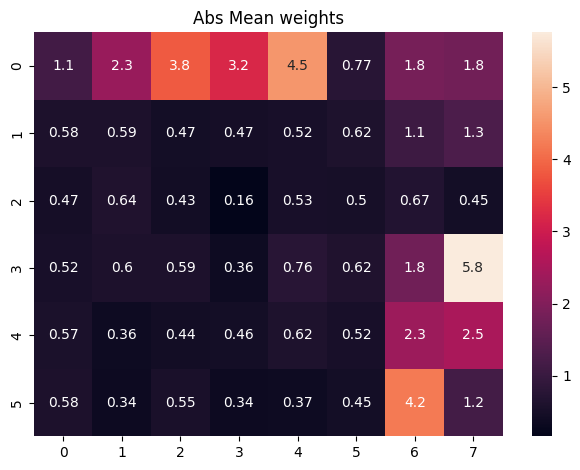

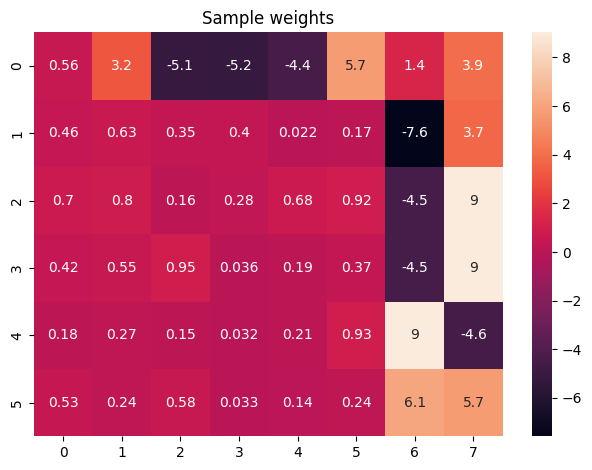

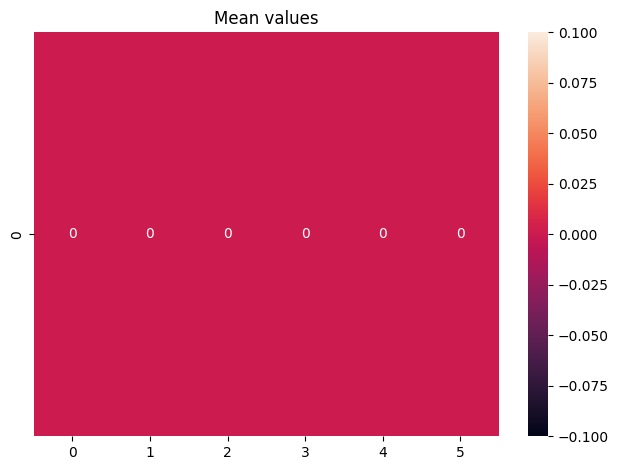

tensor([[0.0651],
        [0.9477],
        [0.9501],
        [0.0501]], grad_fn=<SliceBackward0>)

In [ ]:
def setup():
    complete = CompleteLayer(
        input_size=2,
        hidden_size=5,
        output_size=1,
        values_init=(Zeros, False),  # try initialising differently
        weights_init=(RandomUniform, True),
        scores_init=(RandomUniform, False),
        bias_init=(Zeros, False),
        activation=F.sigmoid,
        use_bias=False
    ).to(device)
    optim = torch.optim.Adam(complete.parameters(), lr=0.01)
    return {
        'model': complete,
        'optimiser': optim
    }

visualisers, result = experiments.run(
    tries=5,
    seed=0,
    setup_fn=setup,
    visualisers=[
        LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        ),
        # LineVisualiser(
        #     lambda r: (r['val_steps'], r['val_losses']),
        #     xlabel='Step',
        #     ylabel='Validation Loss'
        # ),
        WeightVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            show = ['mean', 'std', 'abs-mean', 'sample']
        ),
        WeightVisualiser(
            lambda r: r['model'].values,
            name = 'values',
            show = ['mean']
        )
    ],
    n_epochs=10000,
    train_dataloader=dataloader,
    train_criterion=losses.MSELoss(),
    # val_dataloader=dataloader,
    # val_criterion=losses.MSELoss(),
    early_stop=3e-3,
    pruner=PruneEnsemble({})
)

# compare with other pruning methods
complete = result['model'].to('cpu')
complete.weights = nn.Parameter(complete.weights.triu())
complete(x)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


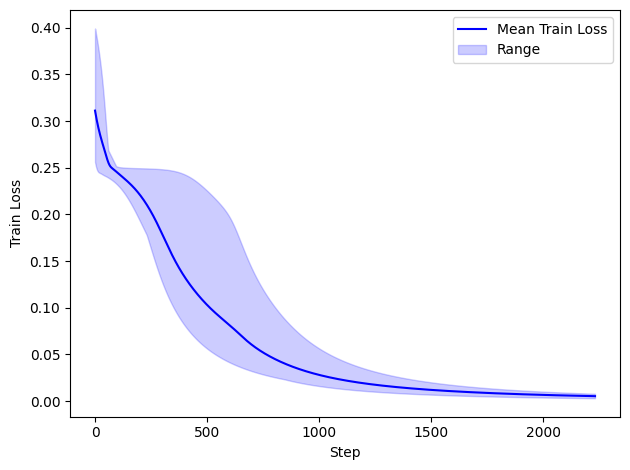

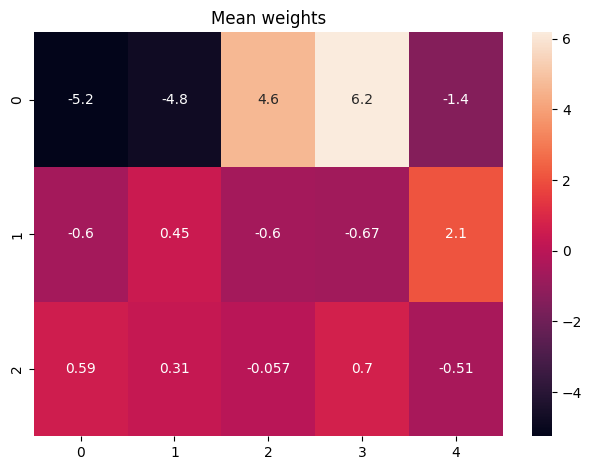

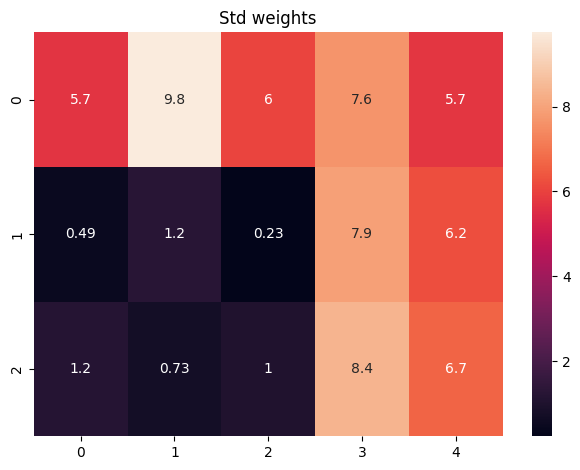

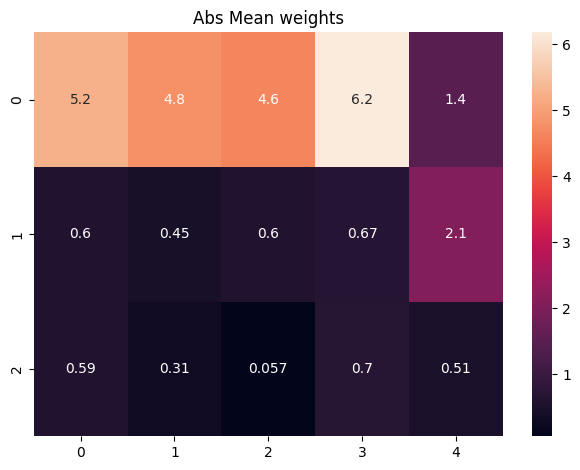

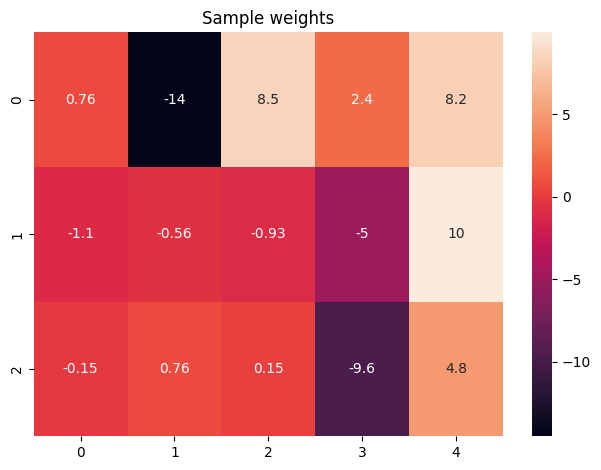

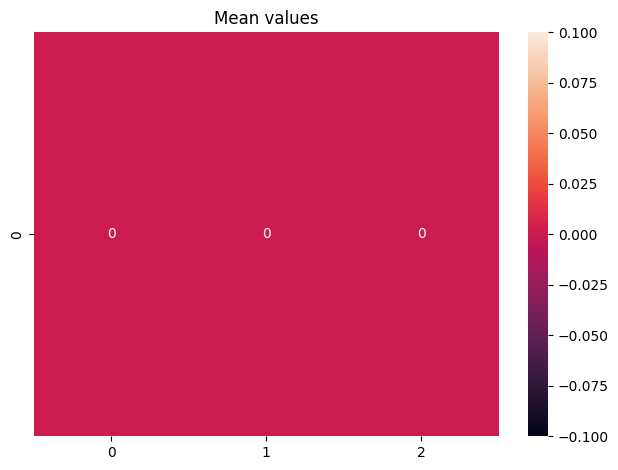

tensor([[0.0687],
        [0.9540],
        [0.9465],
        [0.0478]], grad_fn=<SliceBackward0>)

In [10]:
def setup():
    complete = CompleteLayer(
        input_size=2,
        hidden_size=2,
        output_size=1,
        values_init=(Zeros, False),  # try initialising differently
        weights_init=(RandomNormal, True),
        scores_init=(RandomUniform, False),
        bias_init=(Zeros, False),
        activation=F.sigmoid,
        use_bias=False
    ).to(device)
    optim = torch.optim.Adam(complete.parameters(), lr=0.01)
    return {
        'model': complete,
        'optimiser': optim
    }

visualisers, result = experiments.run(
    tries=5,
    seed=12,
    setup_fn=setup,
    visualisers=[
        LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        ),
        # LineVisualiser(
        #     lambda r: (r['val_steps'], r['val_losses']),
        #     xlabel='Step',
        #     ylabel='Validation Loss'
        # ),
        WeightVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            show = ['mean', 'std', 'abs-mean', 'sample']
        ),
        WeightVisualiser(
            lambda r: r['model'].values,
            name = 'values',
            show = ['mean']
        )
    ],
    n_epochs=10000,
    train_dataloader=dataloader,
    train_criterion=losses.MSELoss(),
    # val_dataloader=dataloader,
    # val_criterion=losses.MSELoss(),
    early_stop=3e-3,
    pruner=PruneEnsemble({})
)

# compare with other pruning methods
complete = result['model'].to('cpu')
complete.weights = nn.Parameter(complete.weights.triu())
complete(x)

100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


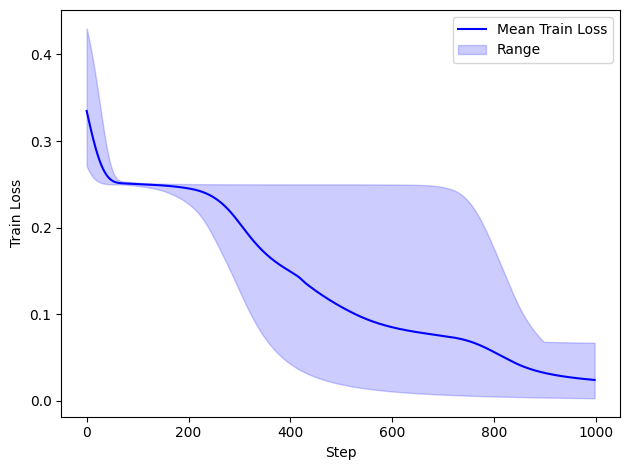

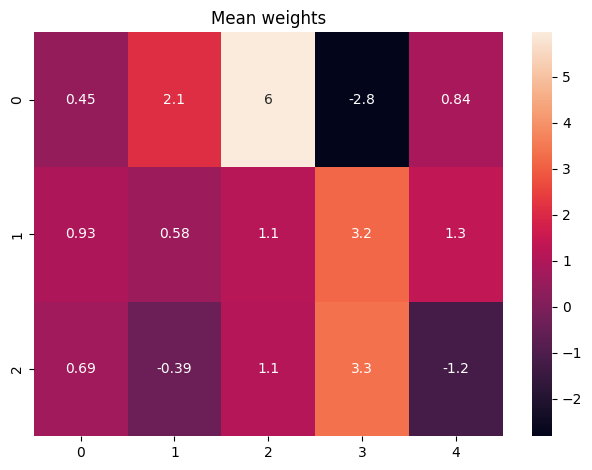

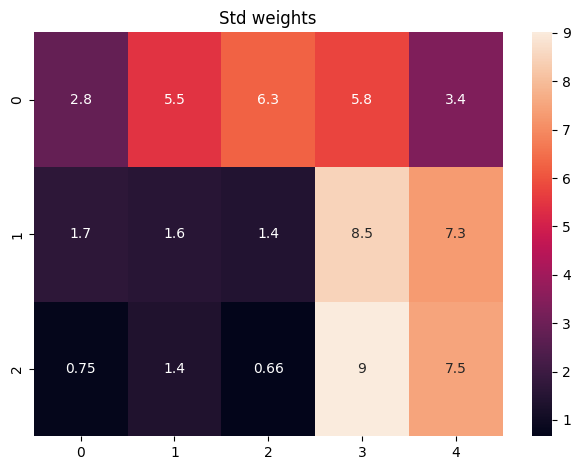

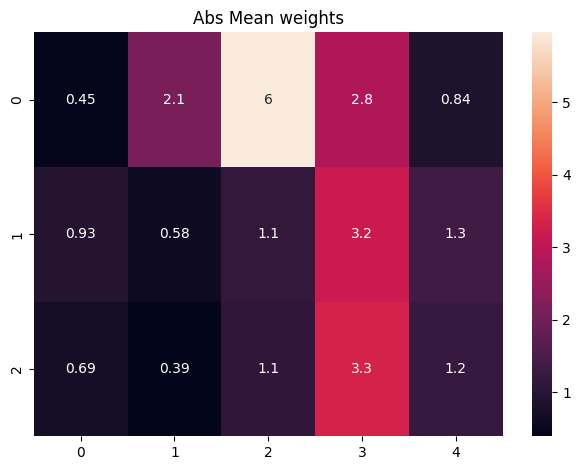

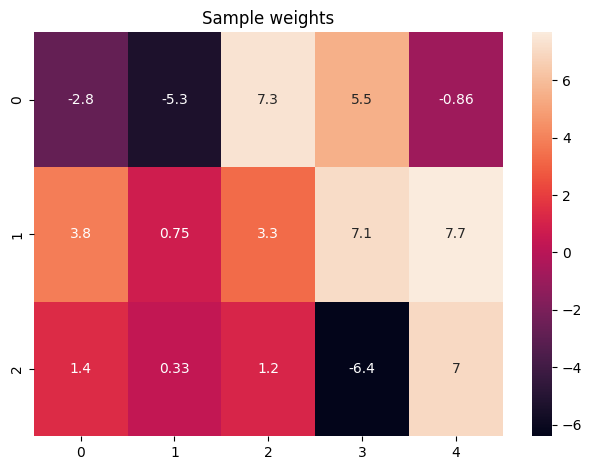

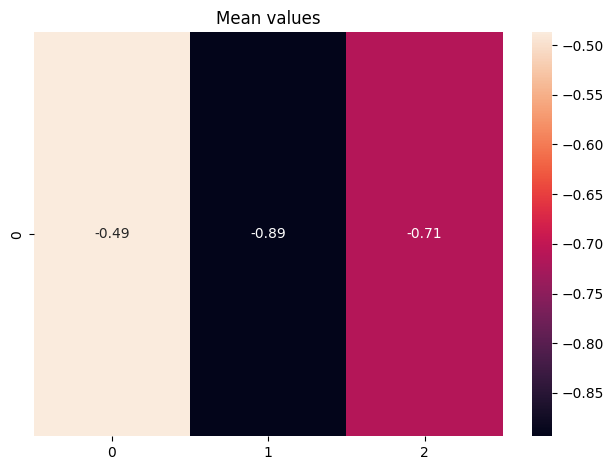

tensor([[0.4298],
        [0.9536],
        [0.9470],
        [0.0915]], grad_fn=<SliceBackward0>)

In [11]:
def setup():
    complete = CompleteLayer(
        input_size=2,
        hidden_size=2,
        output_size=1,
        values_init=(RandomNormal, True),  # try initialising differently
        weights_init=(RandomUniform, True),
        scores_init=(RandomUniform, False),
        bias_init=(Zeros, False),
        activation=F.sigmoid,
        use_bias=False
    ).to(device)
    optim = torch.optim.Adam(complete.parameters(), lr=0.01)
    return {
        'model': complete,
        'optimiser': optim
    }

visualisers, result = experiments.run(
    tries=5,
    seed=15,
    setup_fn=setup,
    visualisers=[
        LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        ),
        # LineVisualiser(
        #     lambda r: (r['val_steps'], r['val_losses']),
        #     xlabel='Step',
        #     ylabel='Validation Loss'
        # ),
        WeightVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            show = ['mean', 'std', 'abs-mean', 'sample']
        ),
        WeightVisualiser(
            lambda r: r['model'].values,
            name = 'values',
            show = ['mean']
        )
    ],
    n_epochs=10000,
    train_dataloader=dataloader,
    train_criterion=losses.MSELoss(),
    # val_dataloader=dataloader,
    # val_criterion=losses.MSELoss(),
    early_stop=3e-3,
    pruner=PruneEnsemble({})
)

# compare with other pruning methods
complete = result['model'].to('cpu')
complete.weights = nn.Parameter(complete.weights.triu())
complete(x)

100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


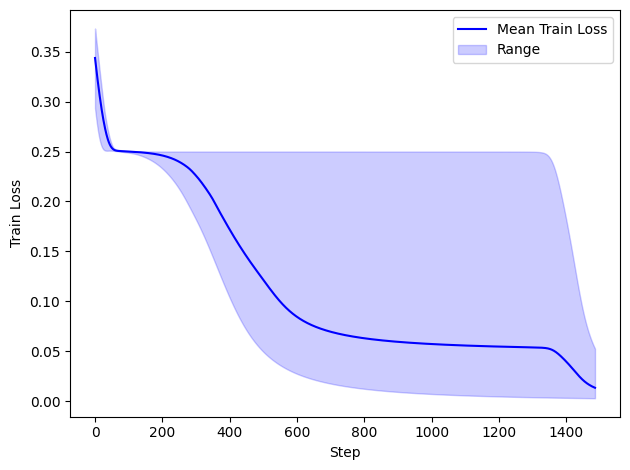

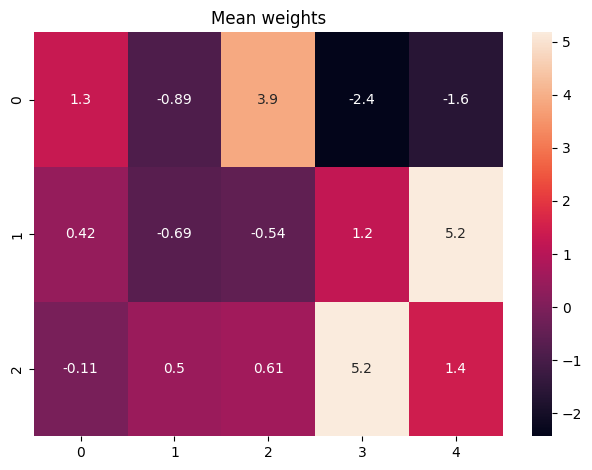

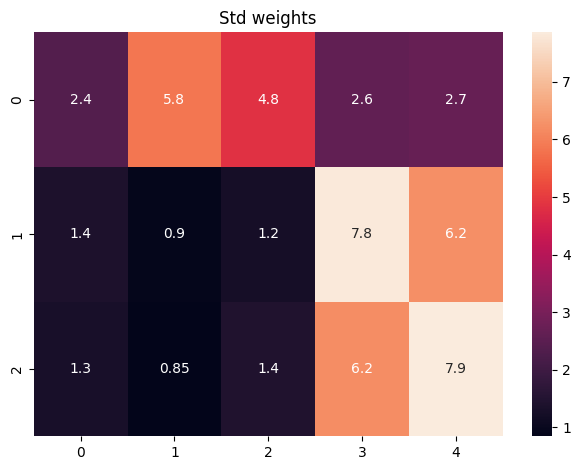

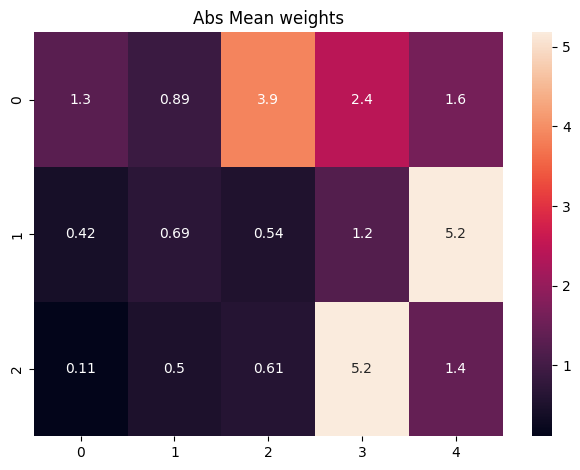

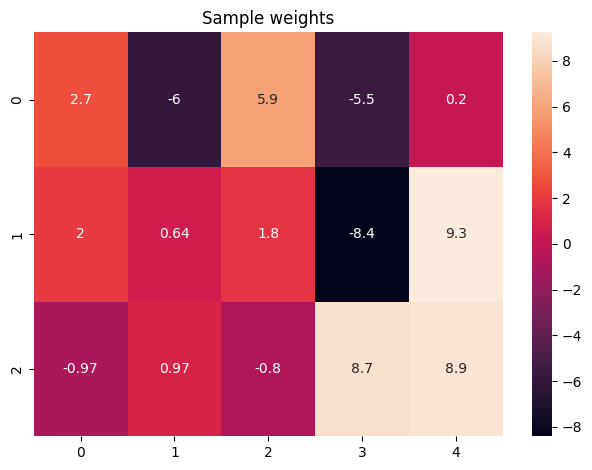

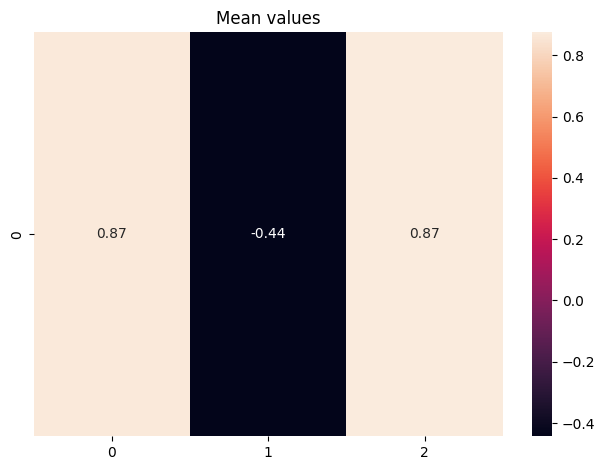

tensor([[0.9743],
        [0.9517],
        [0.9491],
        [0.8753]], grad_fn=<SliceBackward0>)

In [12]:
def setup():
    complete = CompleteLayer(
        input_size=2,
        hidden_size=2,
        output_size=1,
        values_init=(RandomUniform, True),  # try initialising differently
        weights_init=(RandomUniform, True),
        scores_init=(RandomUniform, False),
        bias_init=(Zeros, False),
        activation=F.sigmoid,
        use_bias=False
    ).to(device)
    optim = torch.optim.Adam(complete.parameters(), lr=0.01)
    return {
        'model': complete,
        'optimiser': optim
    }

visualisers, result = experiments.run(
    tries=5,
    seed=6,
    setup_fn=setup,
    visualisers=[
        LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        ),
        # LineVisualiser(
        #     lambda r: (r['val_steps'], r['val_losses']),
        #     xlabel='Step',
        #     ylabel='Validation Loss'
        # ),
        WeightVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            show = ['mean', 'std', 'abs-mean', 'sample']
        ),
        WeightVisualiser(
            lambda r: r['model'].values,
            name = 'values',
            show = ['mean']
        )
    ],
    n_epochs=10000,
    train_dataloader=dataloader,
    train_criterion=losses.MSELoss(),
    # val_dataloader=dataloader,
    # val_criterion=losses.MSELoss(),
    early_stop=3e-3,
    pruner=PruneEnsemble({})
)

# compare with other pruning methods
complete = result['model'].to('cpu')
complete.weights = nn.Parameter(complete.weights.triu())
complete(x)

100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


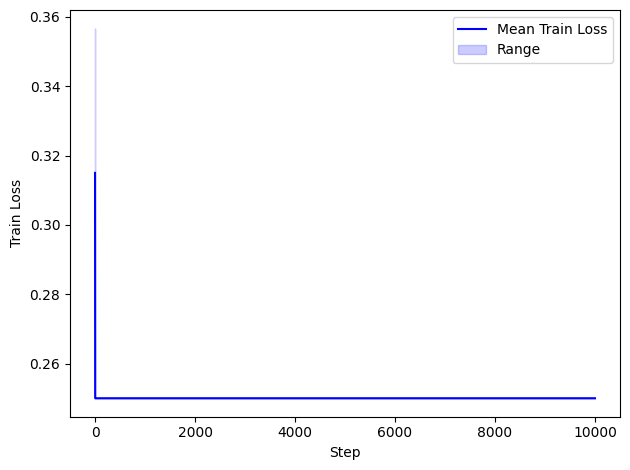

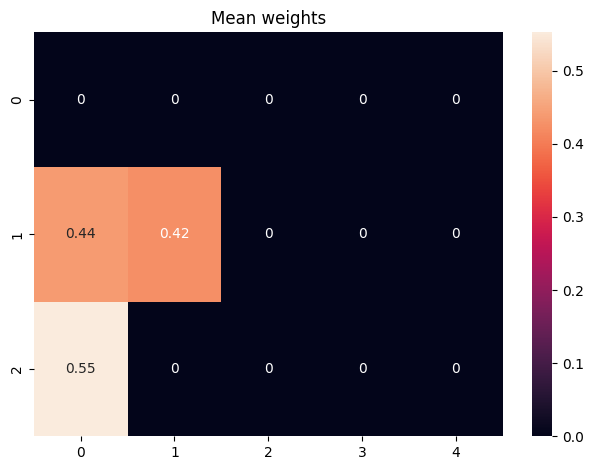

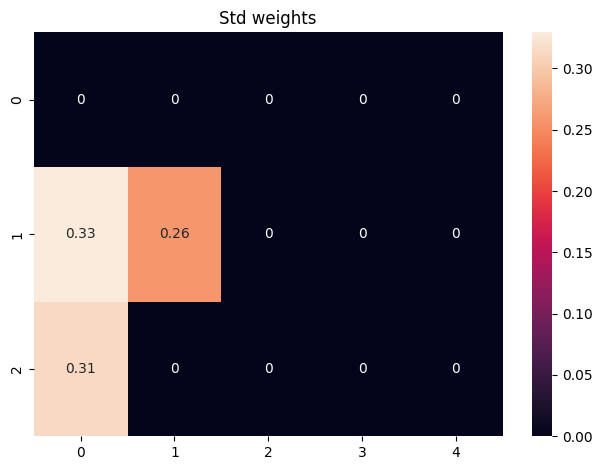

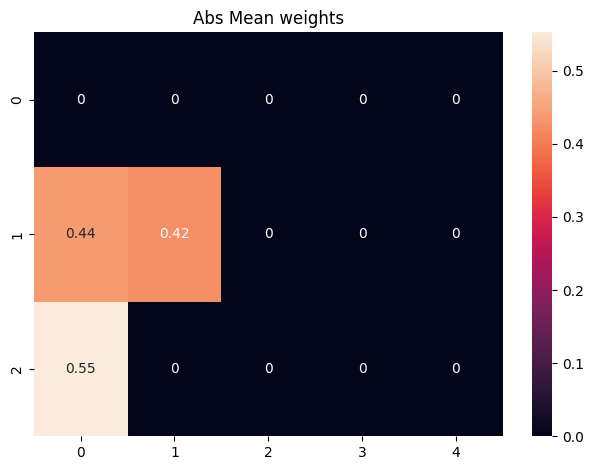

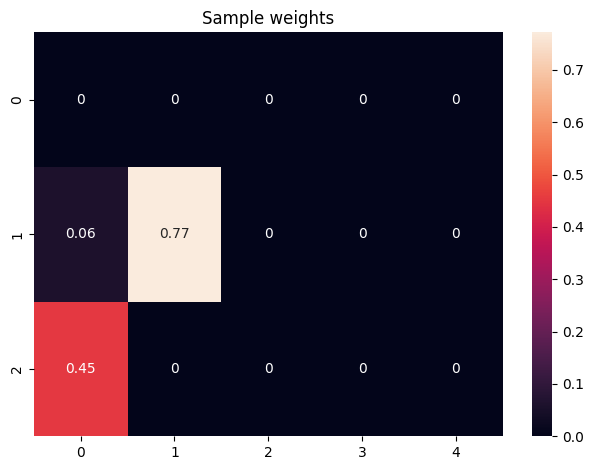

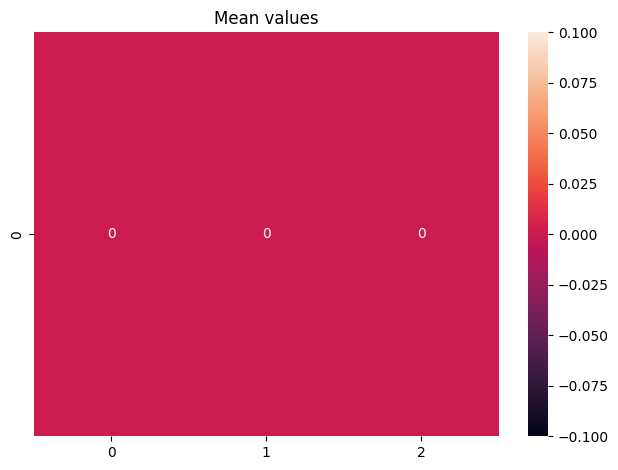

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], grad_fn=<SliceBackward0>)

In [15]:
def setup():
    complete = CompleteLayer(
        input_size=2,
        hidden_size=2,
        output_size=1,
        values_init=(Zeros, False),  # try initialising differently
        weights_init=(RandomUniform, True),
        scores_init=(RandomUniform, False),
        bias_init=(Zeros, False),
        activation=F.sigmoid,
        use_bias=False
    ).to(device)
    optim = torch.optim.Adam(complete.parameters(), lr=0.01)
    return {
        'model': complete,
        'optimiser': optim
    }

visualisers, result = experiments.run(
    tries=5,
    seed=3,
    setup_fn=setup,
    visualisers=[
        LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        ),
        # LineVisualiser(
        #     lambda r: (r['val_steps'], r['val_losses']),
        #     xlabel='Step',
        #     ylabel='Validation Loss'
        # ),
        WeightVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            show = ['mean', 'std', 'abs-mean', 'sample']
        ),
        WeightVisualiser(
            lambda r: r['model'].values,
            name = 'values',
            show = ['mean']
        )
    ],
    n_epochs=10000,
    train_dataloader=dataloader,
    train_criterion=losses.MSELoss(),
    # val_dataloader=dataloader,
    # val_criterion=losses.MSELoss(),
    early_stop=3e-3,
    pruner=PruneEnsemble({
        'weights': RandomPrune(p=0.5)
    })
)

# compare with other pruning methods
complete = result['model'].to('cpu')
complete.weights = nn.Parameter(complete.weights.triu())
complete(x)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


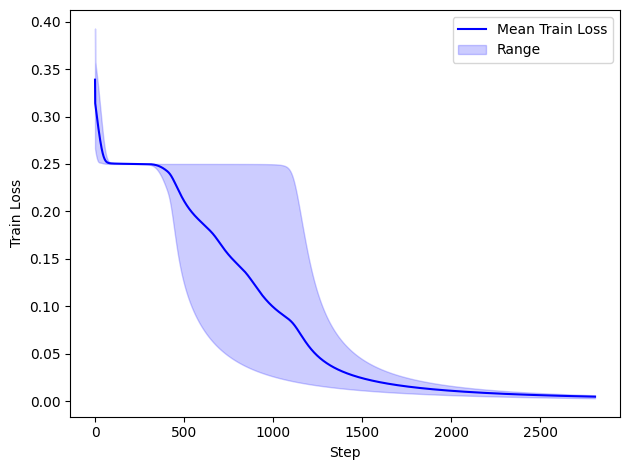

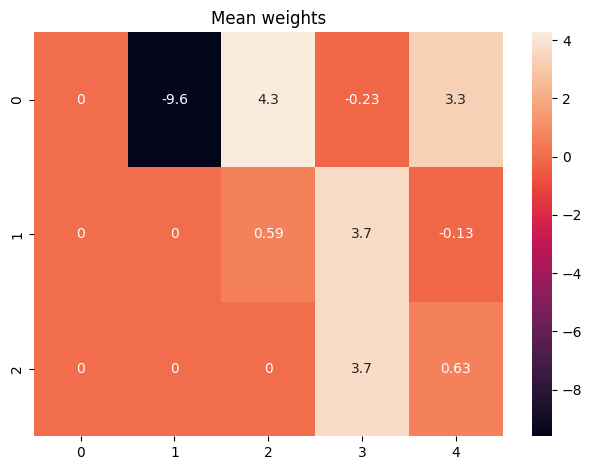

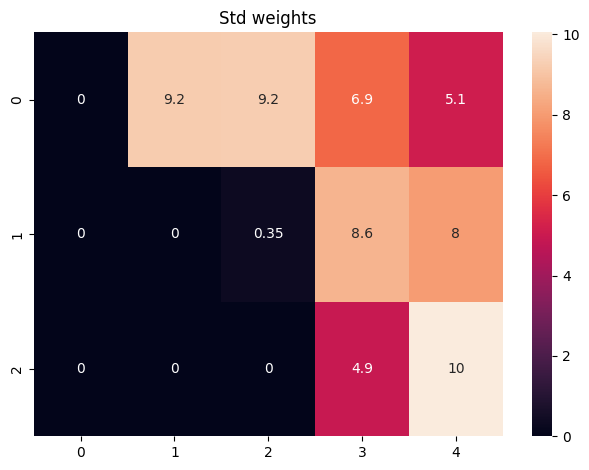

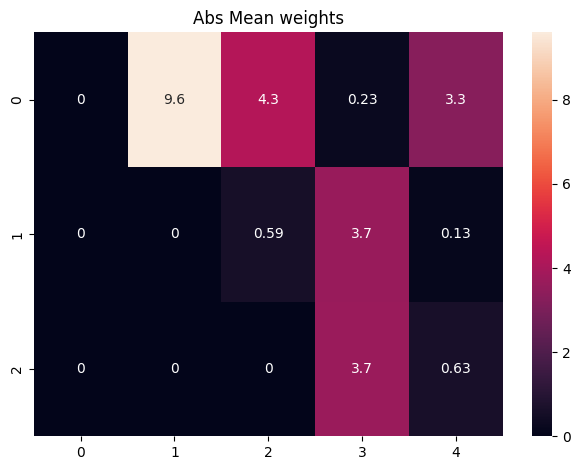

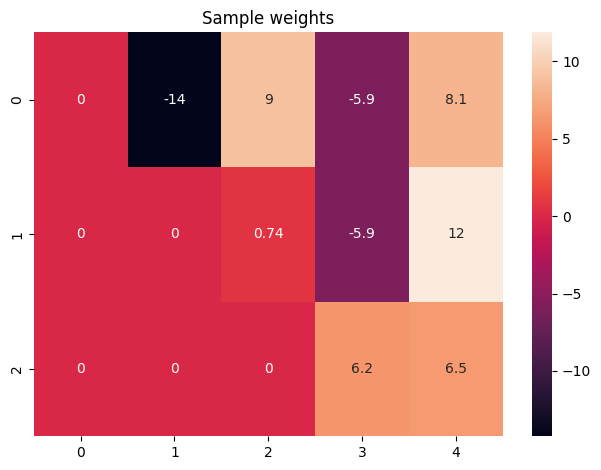

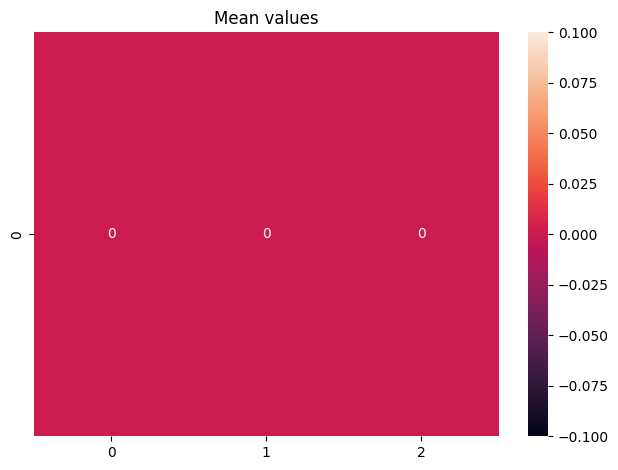

tensor([[0.0653],
        [0.9525],
        [0.9456],
        [0.0501]], grad_fn=<SliceBackward0>)

In [13]:
def setup():
    complete = CompleteLayer(
        input_size=2,
        hidden_size=2,
        output_size=1,
        values_init=(Zeros, False),  # try initialising differently
        weights_init=(RandomUniform, True),
        scores_init=(RandomUniform, False),
        bias_init=(Zeros, False),
        activation=F.sigmoid,
        use_bias=False
    ).to(device)
    optim = torch.optim.Adam(complete.parameters(), lr=0.01)
    return {
        'model': complete,
        'optimiser': optim
    }

visualisers, result = experiments.run(
    tries=5,
    seed=3,
    setup_fn=setup,
    visualisers=[
        LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        ),
        # LineVisualiser(
        #     lambda r: (r['val_steps'], r['val_losses']),
        #     xlabel='Step',
        #     ylabel='Validation Loss'
        # ),
        WeightVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            show = ['mean', 'std', 'abs-mean', 'sample']
        ),
        WeightVisualiser(
            lambda r: r['model'].values,
            name = 'values',
            show = ['mean']
        )
    ],
    n_epochs=10000,
    train_dataloader=dataloader,
    train_criterion=losses.MSELoss(),
    # val_dataloader=dataloader,
    # val_criterion=losses.MSELoss(),
    early_stop=3e-3,
    pruner=PruneEnsemble({
        'weights': TriuPrune()
    })
)

# compare with other pruning methods
complete = result['model'].to('cpu')
complete.weights = nn.Parameter(complete.weights.triu())
complete(x)

100%|██████████| 5/5 [00:22<00:00,  4.50s/it]


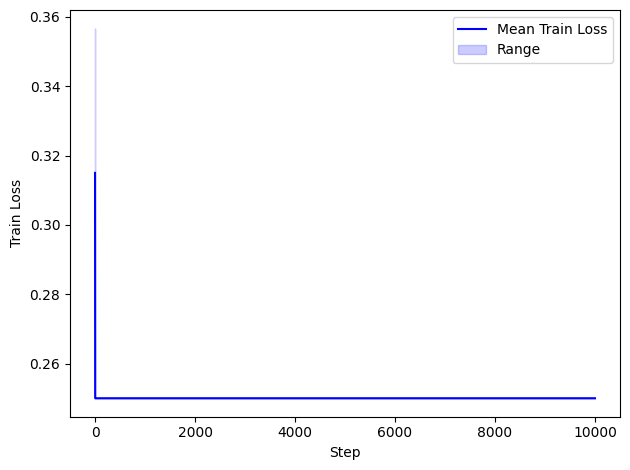

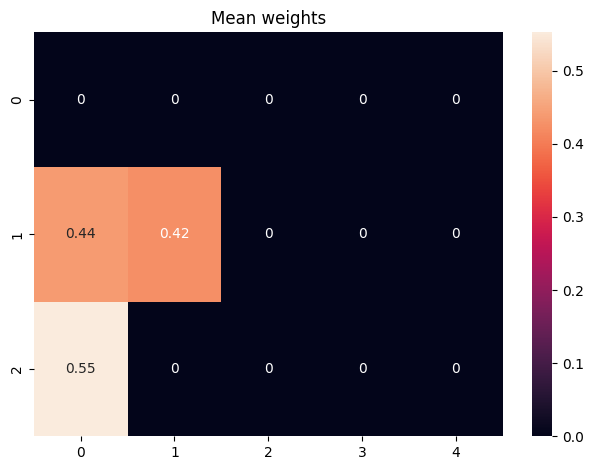

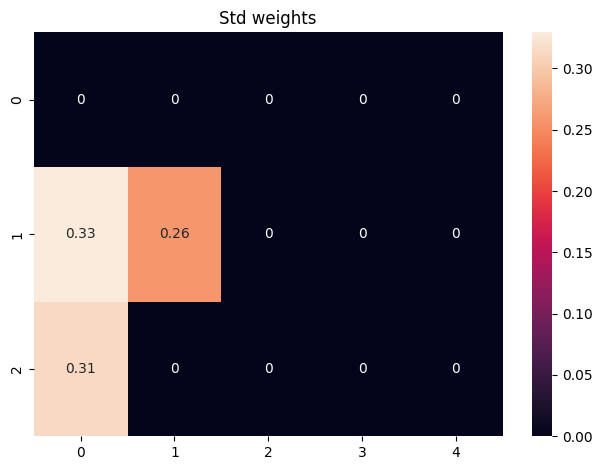

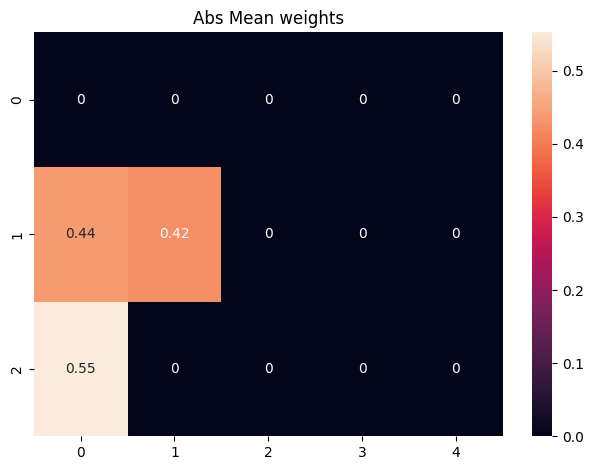

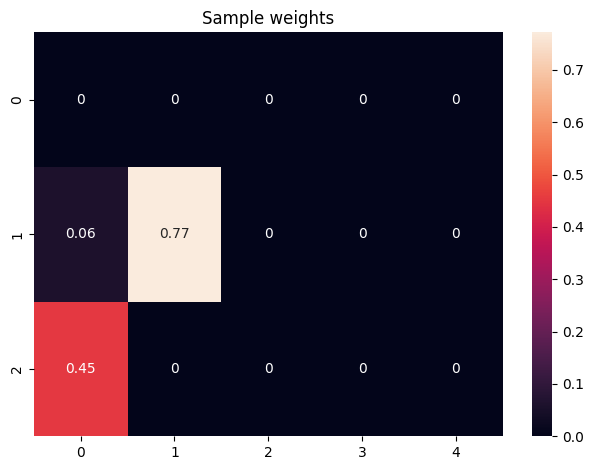

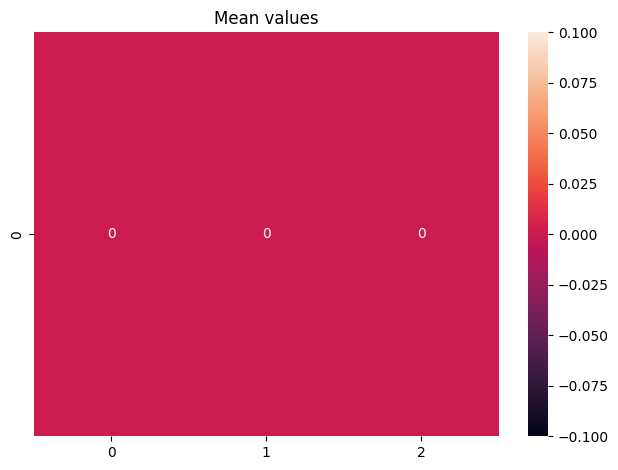

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], grad_fn=<SliceBackward0>)

In [14]:
def setup():
    complete = CompleteLayer(
        input_size=2,
        hidden_size=2,
        output_size=1,
        values_init=(Zeros, False),  # try initialising differently
        weights_init=(RandomUniform, True),
        scores_init=(RandomUniform, False),
        bias_init=(Zeros, False),
        activation=F.sigmoid,
        use_bias=False
    ).to(device)
    optim = torch.optim.Adam(complete.parameters(), lr=0.01)
    return {
        'model': complete,
        'optimiser': optim
    }

visualisers, result = experiments.run(
    tries=5,
    seed=3,
    setup_fn=setup,
    visualisers=[
        LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        ),
        # LineVisualiser(
        #     lambda r: (r['val_steps'], r['val_losses']),
        #     xlabel='Step',
        #     ylabel='Validation Loss'
        # ),
        WeightVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            show = ['mean', 'std', 'abs-mean', 'sample']
        ),
        WeightVisualiser(
            lambda r: r['model'].values,
            name = 'values',
            show = ['mean']
        )
    ],
    n_epochs=10000,
    train_dataloader=dataloader,
    train_criterion=losses.MSELoss(),
    # val_dataloader=dataloader,
    # val_criterion=losses.MSELoss(),
    early_stop=3e-3,
    pruner=PruneEnsemble({
        'weights': RandomPrune(p=0.5, persistent=True)
    })
)

# compare with other pruning methods
complete = result['model'].to('cpu')
complete.weights = nn.Parameter(complete.weights.triu())
complete(x)

**Takeaway**: initialising values to 0 induces topological ordering!

## Towards the final

### Plans 1) Discussion

- Different pruning strategies
- Different initialisation strategies
- Different model sizes

> A theory or explanation?

### Plans 2) Issues
- Learning rate tuning
- Other architectural properties?

### Plans 3) Further Steps

- Extend to MNIST
- Extend beyond MLPs?